In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import curve_fit
from imblearn.under_sampling import RandomUnderSampler
from scipy.optimize import minimize_scalar # 标量最小化函数库
from scipy import stats
plt.rcParams["font.family"]="STSong"
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [52]:
# 读取附件数据
df1 = pd.read_excel('附件1.xlsx')
df2 = pd.read_excel('附件2.xlsx')
df3 = pd.read_excel('附件3.xlsx')
df4 = pd.read_excel('附件4.xlsx')
df2 = df2.query('销售类型 == "销售"') # 仅保留销售类型为销售的

In [53]:
# 按单品分组，计算月均销售单价、月均销量、月均销售额
df2['销售日期'] = pd.to_datetime(df2['销售日期'])
df2['月份'] = df2['销售日期'].dt.month
df2['年份'] = df2['销售日期'].dt.year
df2 = df2.merge(df1, on='单品编码', how='left')
df2['销售额'] = df2['销量(千克)'] * df2['销售单价(元/千克)']
grouped_df2 = df2.groupby(['单品编码', '年份', '月份']).agg({'销售额': 'sum', '销量(千克)': 'sum', '销售单价(元/千克)': 'mean'})
grouped_df2.rename(columns={'销售单价(元/千克)': '月均销售单价', '销量(千克)': '月均销量'}, inplace=True)
grouped_df2 = grouped_df2.reset_index()

In [54]:
# 按月计算月均批发价格
df3['销售日期'] = pd.to_datetime(df3['销售日期'])
df3['月份'] = df3['销售日期'].dt.month
df3['年份'] = df3['销售日期'].dt.year
grouped_df3 = df3.groupby(['单品编码', '年份', '月份']).agg({'批发价格(元/千克)': 'mean'})
grouped_df3.rename(columns={'批发价格(元/千克)': '月均批发价格'}, inplace=True)
grouped_df3 = grouped_df3.reset_index()

In [55]:
# 合并数据，计算月均成本和月均利润
merged_df = grouped_df2.merge(grouped_df3, on=['单品编码', '年份', '月份'], how='left')
merged_df = merged_df.merge(df4, on='单品编码', how='left')
merged_df['月均成本'] = merged_df['月均销量'] * (1 + merged_df['损耗率(%)'] / 100) * merged_df['月均批发价格']
merged_df['月均利润'] = merged_df['销售额'] - merged_df['月均成本']

In [56]:
# 按蔬菜品类汇总，得到各蔬菜品类的月均销量、月均销售额、月均成本和月均利润
merged_df = merged_df.merge(df1[['单品编码', '分类名称']], on='单品编码', how='left')
grouped_merged_df = merged_df.groupby(['分类名称', '年份', '月份']).agg({'月均销量': 'sum', '销售额': 'sum', '月均成本': 'sum', '月均利润': 'sum'})
grouped_merged_df = grouped_merged_df.reset_index()

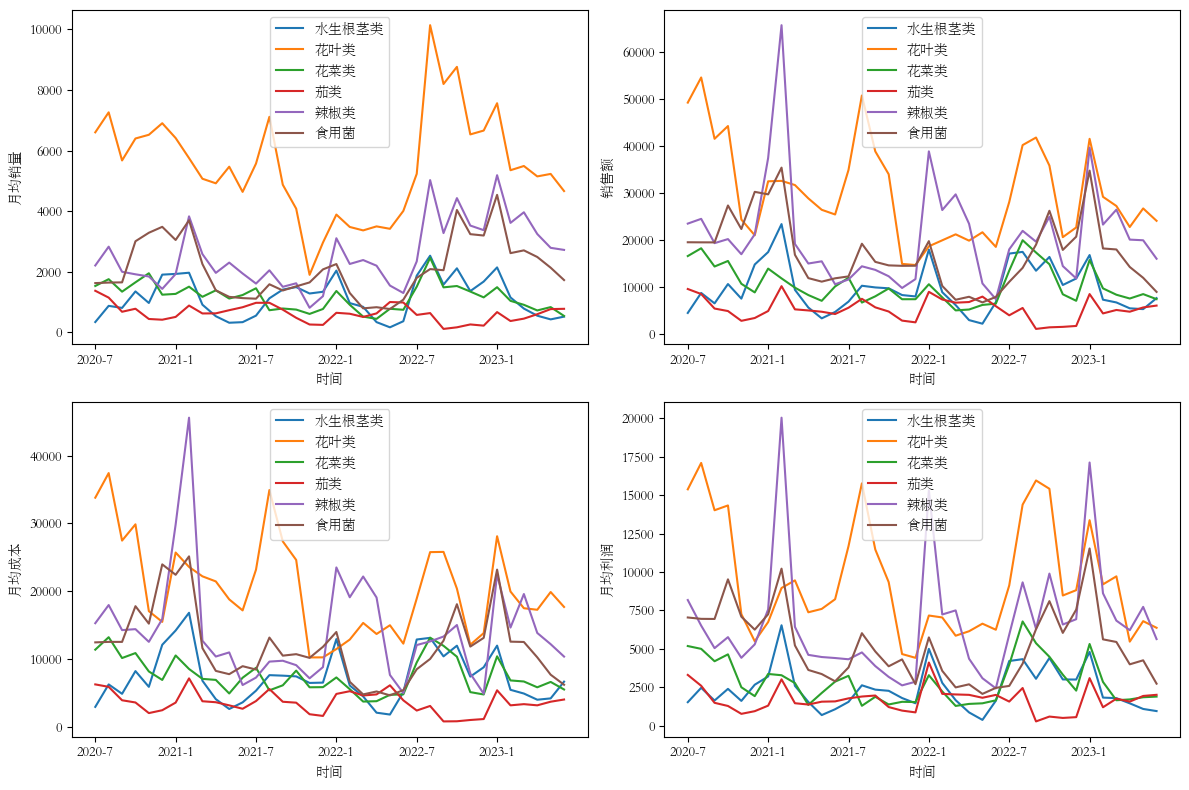

In [57]:
# 画出各品类蔬菜的月均销量、月均销售额、月均成本和月均利润的折线图
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, col in enumerate(['月均销量', '销售额', '月均成本', '月均利润']):
    ax = axes[i // 2, i % 2]
    for cat in grouped_merged_df['分类名称'].unique():
        sub_df = grouped_merged_df[grouped_merged_df['分类名称'] == cat]
        ax.plot(sub_df['年份'].astype(str) + '-' + sub_df['月份'].astype(str), sub_df[col], label=cat)
    ax.set_xlabel('时间')
    ax.set_ylabel(col)
    ax.legend()
    ax.set_xticks(ax.get_xticks()[::6])
plt.tight_layout()
plt.savefig('销量利润等折线图.png', dpi=600)

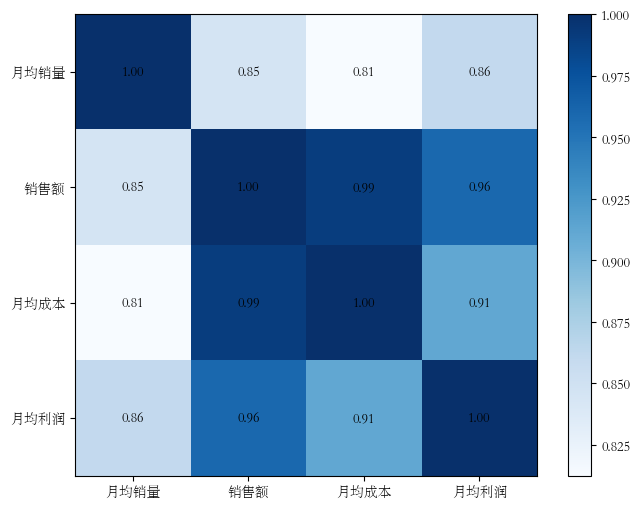

In [58]:
# 计算各指标的相关系数热力图
corr_matrix = grouped_merged_df[['月均销量', '销售额', '月均成本', '月均利润']].corr()
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='Blues')
plt.colorbar()
plt.xticks(range(4), ['月均销量', '销售额', '月均成本', '月均利润'])
plt.yticks(range(4), ['月均销量', '销售额', '月均成本', '月均利润'])
for i in range(4):
    for j in range(4):
        plt.text(i, j, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center')
plt.savefig('销量利润等指标热力图.png', dpi=600)


花叶类的回归方程为：y = 289.22 + -11.41x
食用菌的回归方程为：y = 163.81 + -2.41x
辣椒类的回归方程为：y = 291.00 + -9.18x
茄类的回归方程为：y = 292.82 + -15.39x
花菜类的回归方程为：y = 663.25 + -15.85x
水生根茎类的回归方程为：y = 473.23 + -18.43x


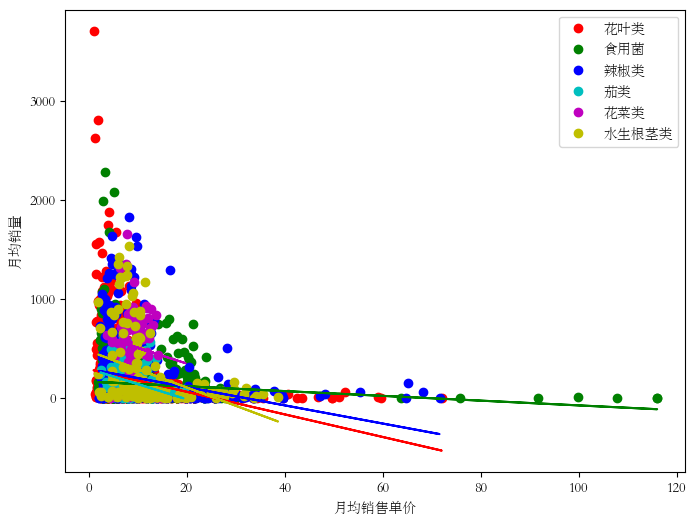

In [59]:
# 画出月均销售单价-月均销量的关系图，用OLS方法拟合出月均销量和月均销售单价的关系
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y'] # 定义不同品类的颜色
for i, cat in enumerate(merged_df['分类名称'].unique()):
    sub_df = merged_df[merged_df['分类名称'] == cat]
    plt.scatter(sub_df['月均销售单价'], sub_df['月均销量'], label=cat, color=colors[i]) # 修改了这里的颜色
    X = sm.add_constant(sub_df['月均销售单价'])
    y = sub_df['月均销量']
    model = sm.OLS(y, X).fit()
    plt.plot(sub_df['月均销售单价'], model.predict(X), color=colors[i]) # 修改了这里的颜色
    print(f'{cat}的回归方程为：y = {model.params[0]:.2f} + {model.params[1]:.2f}x') # 输出了回归方程
plt.xlabel('月均销售单价')
plt.ylabel('月均销量')
plt.legend()
plt.savefig('单价-销量曲线图.png', dpi=600)

# 计算评价指标和t检验值，保存为csv
results = []
for cat in merged_df['分类名称'].unique():
    sub_df = merged_df[merged_df['分类名称'] == cat]
    X = sm.add_constant(sub_df['月均销售单价'])
    y = sub_df['月均销量']
    model = sm.OLS(y, X).fit()
    r2 = model.rsquared
    rmse = np.sqrt(model.mse_resid)
    t_value = model.tvalues[1]
    p_value = model.pvalues[1] # 计算了p值
    results.append([cat, r2, rmse, t_value, p_value]) # 添加了p值
results_df = pd.DataFrame(results, columns=['分类名称', 'r^2', 'rmse', 't检验值', 'p值']) # 添加了p值
results_df.to_csv('单价-销量曲线评价指标.csv', index=False, encoding='utf_8_sig')

In [60]:
# 对数据按月均销售单价进行随机下采样
rus = RandomUnderSampler(random_state=0) # 创建随机下采样对象
X = merged_df['月均销售单价'].values.reshape(-1, 1) # 将月均销售单价转换为二维数组
y = merged_df['分类名称'] # 将分类名称作为目标变量
X_resampled, y_resampled = rus.fit_resample(X, y) # 对数据进行随机下采样
resampled_df = pd.DataFrame({'月均销售单价': X_resampled.flatten(), '分类名称': y_resampled}) # 将下采样后的数据转换为数据框
resampled_df = resampled_df.merge(merged_df, on=['月均销售单价', '分类名称']) # 将下采样后的数据与原始数据合并，保留其他特征

水生根茎类的回归方程为：y = 925.02*exp(-((x-7.60)/3.65)^2)
花叶类的回归方程为：y = 283.95*exp(-((x-9.42)/5.85)^2)
花菜类的回归方程为：y = 1563.51*exp(-((x-10.23)/5.47)^2)
茄类的回归方程为：y = 333.02*exp(-((x-7.17)/6.18)^2)
辣椒类的回归方程为：y = 520.63*exp(-((x-7.05)/7.78)^2)
食用菌的回归方程为：y = 347.51*exp(-((x-18.19)/13.29)^2)


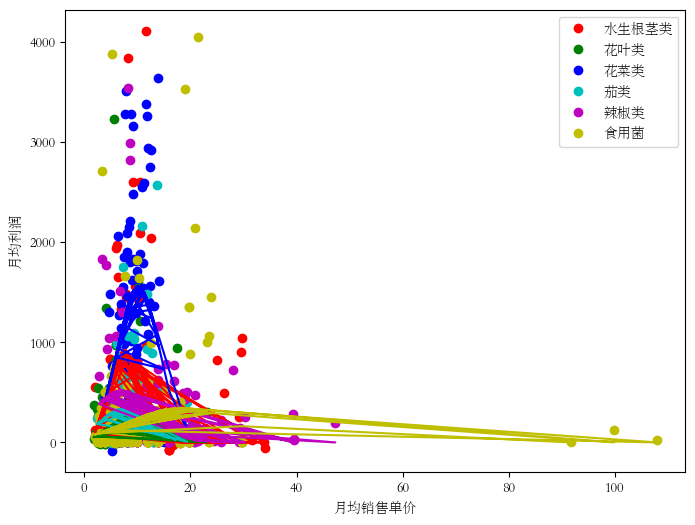

In [61]:
# 定义一个高斯函数的形式，用于非线性回归
def gauss_func(x, a1, b1, c1):
    return a1 * np.exp(-((x - b1) / c1)**2) # 定义高斯函数的形式

# 画出月均利润-月均销售单价的关系图，用非线性回归方法拟合出月均利润和月均销售单价的关系
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y'] # 定义不同品类的颜色
for i, cat in enumerate(resampled_df['分类名称'].unique()):
    sub_df = resampled_df[resampled_df['分类名称'] == cat]
    if cat == '辣椒类':
        sub_df = sub_df[sub_df['月均销售单价'] <= 60] # 筛选出月均销售单价不超过 60 的数据
    plt.scatter(sub_df['月均销售单价'], sub_df['月均利润'], label=cat, color=colors[i]) 
    X = sub_df['月均销售单价']
    y = sub_df['月均利润']
    popt, pcov = curve_fit(gauss_func, X, y, maxfev=1000) # 使用非线性回归拟合参数
    plt.plot(X, gauss_func(X, *popt), color=colors[i]) 
    print(f'{cat}的回归方程为：y = {popt[0]:.2f}*exp(-((x-{popt[1]:.2f})/{popt[2]:.2f})^2)') # 输出了回归方程
plt.xlabel('月均销售单价')
plt.ylabel('月均利润')
plt.legend()
plt.savefig('单价-利润曲线图关系图.png', dpi=600)

In [62]:
# 计算评价指标和检验值，保存为csv
results = []
for cat in resampled_df['分类名称'].unique():
    sub_df = resampled_df[resampled_df['分类名称'] == cat]
    if cat == '辣椒类':
        sub_df = sub_df[sub_df['月均销售单价'] <= 60] # 筛选出月均销售单价不超过 60 的数据
    X = sub_df['月均销售单价']
    y = sub_df['月均利润']
    model = curve_fit(gauss_func, X, y) # 使用非线性回归拟合参数
    model_fit = model[0]
    r_squared = 1 - (np.sum((y - gauss_func(X, *model_fit))**2) / np.sum((y - np.mean(y))**2)) # 计算 R^2
    f_value = (r_squared / (1 - r_squared)) * (len(y) - len(model_fit)) / (len(model_fit) - 1) # 计算 F 检验值
    p_value = stats.f.sf(f_value, len(model_fit) - 1, len(y) - len(model_fit)) # 计算 p 值
    results.append([cat,  r_squared, f_value, p_value])
results_df = pd.DataFrame(results, columns=['分类名称',  'rmse', 'F检验值', 'p值'])
results_df.to_csv('单价-利润曲线评价指标.csv', index=False,  encoding='utf_8_sig')

In [63]:
# 优化月均利润，找到最大值，得到对应品类的单价和补货量
prices = []
profits = []
replenishments = []
for cat in resampled_df['分类名称'].unique():
    sub_df = resampled_df[resampled_df['分类名称'] == cat]
    if cat == '辣椒类':
        sub_df = sub_df[sub_df['月均销售单价'] <= 60] # 筛选出月均销售单价不超过 60 的数据
    X = sub_df['月均销售单价']
    y = sub_df['月均利润']
    y = sub_df['月均利润']
    popt, pcov = curve_fit(gauss_func, X, y, maxfev=1000) # 使用非线性回归拟合参数
    a1 = popt[0]
    b1 = popt[1]
    c1 = popt[2]
    def profit_func(x): # 定义利润函数，用于寻优
        return -gauss_func(x, a1, b1, c1) # 取负号是因为要求最大值，而寻优函数默认求最小值
    bounds = (0.01, 100) # 设置单价的下界为0.01，上界为100
    result = minimize_scalar(profit_func, bounds = bounds) # 使用标量最小化函数寻优
    p_opt = result.x # 得到最优单价
    profit_opt = -result.fun # 得到最大利润
    prices.append([cat, p_opt])
    profits.append([cat, profit_opt])
    q_opt = np.interp(p_opt, X, sub_df['月均销量']) # 使用线性插值方法得到对应的月均销量
    r_dict = dict(zip(sub_df['单品编码'], sub_df['损耗率(%)'])) # 创建一个字典，存储每个商品编码和对应的损耗率
    w_dict = dict(sub_df.groupby('单品编码')['月均销量'].sum() / sub_df['月均销量'].sum()) # 创建一个字典，存储每个商品编码和对应的销量占比
    r = sum([r_dict[k] * w_dict[k] for k in r_dict]) / 100 # 计算损耗率的加权平均值
    replenishment_opt = q_opt * (1 + r) # 计算补货量
    replenishments.append([cat, replenishment_opt])
prices_df = pd.DataFrame(prices, columns=['分类名称', '最优单价'])
prices_df.to_csv('最优单价.csv', index=False,  encoding='utf_8_sig')
profits_df = pd.DataFrame(profits, columns=['分类名称', '最大利润']) 
profits_df.to_csv('最大利润.csv', index=False,  encoding='utf_8_sig')
replenishments_df = pd.DataFrame(replenishments, columns=['分类名称', '补货量']) 
replenishments_df.to_csv('补货量.csv', index=False,  encoding='utf_8_sig')